In [1]:
import os
import glob
import pandas as pd
import numpy as np
from collections import Counter,defaultdict
import re
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_pickle('../data_scraping/dedup_combined_df.pkl')
df.head(10)

,url,title,date,domain,stance,topic,is_AP,year,pretty_domain,month
0,www.buzzfeednews.com/article/tasneemnashrulla/...,"""eat the babies"" viral video at aoc town hall ...",2019-10-04 00:00:00,buzzfeed,pro,cc,None,2019.0,Buzzfeed,10.0
1,www.buzzfeednews.com/article/passantino/extrem...,"""extremely likely"" global warming is man-made,...",2013-09-27 00:00:00,buzzfeed,pro,cc,None,2013.0,Buzzfeed,9.0
2,shotofprevention.com/2010/11/03/history-makes-...,"""history"" makes headlines with launch of new w...",2020-03-13 14:32:02,https://shotofprevention/,pro,vax,False,2020.0,Shot of Prevention,3.0
3,www.buzzfeednews.com/article/andrewkaczynski/i...,"""it's global warming, stupid"" - buzzfeed news",2012-11-01 00:00:00,buzzfeed,pro,cc,None,2012.0,Buzzfeed,11.0
4,www.buzzfeednews.com/article/tasneemnashrulla/...,"""japan dropped an atomic bomb on america durin...",2014-02-24 00:00:00,buzzfeed,pro,cc,None,2014.0,Buzzfeed,2.0
5,www.buzzfeednews.com/article/llevin/opinion-im...,"""look at my record, child"": joe biden showed m...",2019-10-31 00:00:00,buzzfeed,pro,cc,None,2019.0,Buzzfeed,10.0
6,www.breitbart.com/politics/2019/06/14/orourke-...,"""president o'rourke will end oil and gas lease...",2019-06-14 00:00:00,breitbart,anti,cc,None,2019.0,Breitbart,6.0
7,www.buzzfeednews.com/article/andrewkaczynski/s...,smoking doesnt kill and other great old opeds ...,2015-03-31 00:00:00,buzzfeed,pro,cc,None,2015.0,Buzzfeed,3.0
8,www.foxnews.com/world/100-carbon-tax-by-2030-c...,"$100 carbon tax by 2030 could save climate, sa...",2017-05-29 00:00:00,fox,anti,cc,None,2017.0,Fox,5.0
9,childrenshealthdefense.org/news/4-billion-and-...,$4 billion and growing: u.s. payouts for vacc...,2018-11-19 00:00:00,chd,anti,vax,None,2018.0,Children's Health Defense,11.0


In [3]:
TOPICS = ['cc','vax']
SIDES = ['pro','anti']

In [80]:
BLACKLIST_SUBJS = set(['that','one','this','percent','’s','some','many','those','other','“','who',
                      '—','which'])

In [4]:
cc_df = df.loc[df.topic=='cc']
vax_df = df.loc[df.topic=='vax']

In [5]:
good_quotes = pickle.load(open('../data_processing/good_coref_quotes.pkl','rb'))

In [6]:
len(good_quotes)

434634

In [170]:
good_quotes[0].keys()

dict_keys(['quote lemmas', 'quote lemmas coref', 'verb lemmas', 'verb lemmas coref', 'main verb lemma', 'main verb lemma coref', 'subject lemmas', 'subject lemmas coref', 'main subject lemma', 'main subject lemma coref', 'neg lemmas', 'main neg lemma', 'quote text', 'verb text', 'main verb text', 'subject text', 'main subject text', 'is neg', 'source', 'stance', 'topic'])

In [44]:
good_quotes[0]

{'quote lemmas': ['climate', 'change', 'be', 'a', 'hoax'],
 'quote lemmas coref': ['climate', 'change', 'be', 'a', 'hoax'],
 'verb lemmas': ['believe'],
 'verb lemmas coref': ['believe'],
 'main verb lemma': 'believe',
 'main verb lemma coref': 'believe',
 'subject lemmas': ['the',
  'pro',
  '-',
  'Trump',
  'LaRouche',
  'PAC',
  ',',
  'which',
  'believe',
  ','],
 'subject lemmas coref': ['the',
  'pro',
  '-',
  'Trump',
  'LaRouche',
  'PAC',
  ',',
  'which',
  'believe',
  ','],
 'main subject lemma': 'PAC',
 'main subject lemma coref': 'PAC',
 'neg lemmas': None,
 'main neg lemma': None,
 'quote text': ['climate', 'change', 'is', 'a', 'hoax'],
 'verb text': ['believes'],
 'main verb text': 'believes',
 'subject text': ['the',
  'pro',
  '-',
  'Trump',
  'LaRouche',
  'PAC',
  ',',
  'which',
  'believes',
  ','],
 'main subject text': 'PAC',
 'is neg': None,
 'source': 'www.buzzfeednews.com/article/tasneemnashrulla/eat-babies-aoc-town-hall-pro-trump-troll-larouche'}

In [75]:
ent_fuzzy_map = pickle.load(open('named_entity_fuzzymatch_map.pkl','rb'))

### Clean superfluous whitespace

In [163]:
import re
re.sub("\s\s+",'','"   e&e')

'"e&e'

In [166]:
whitespace_cleaned_quotes = []
for q in good_quotes:
    for key in ['main verb lemma','main verb lemma coref','main subject lemma','main subject lemma coref']:
        if q[key] is not None:
            q[key] = re.sub("\s\s+",'',q[key])
    whitespace_cleaned_quotes.append(q)

In [167]:
pickle.dump(whitespace_cleaned_quotes,open('../data_processing/good_coref_quotes.pkl','wb'))

### Add outlet stance, topic fields to each quote

In [46]:
#updated_quotes = []

In [51]:
for q in good_quotes[10:]:
    stance = get_src_attr(q['source'],'stance')
    topic = get_src_attr(q['source'],'topic')
    q.update({'stance':stance,'topic':topic})
    updated_quotes.append(q)

In [56]:
len(good_quotes),len(updated_quotes)

(434634, 434634)

In [58]:
pickle.dump(updated_quotes,open('../data_processing/good_coref_quotes.pkl','wb'))

### Fuzzy matching to collapse subj entities

In [121]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [148]:
NAMED_ENTS = ['ocasio-cortez','thunberg','sanders','al gore','trump','obama','bill gates','hillary clinton',
             'bill clinton','william happer','']

In [203]:
# Make sure main_subjs_dict is up to date!

ent_fuzzy_dict = defaultdict(list)
for ent in NAMED_ENTS:
    fuzzy_matches = [x[0] for x in process.extract(ent, 
                                                   list(Counter(main_subjs_dict['cc']['anti']).keys())+\
                                                   list(Counter(main_subjs_dict['cc']['pro']).keys()), limit=100) 
 if x[1] >= 85 and len(x[0])>=len(ent)][:30]
    ent_fuzzy_dict[ent] = fuzzy_matches

In [204]:
ent_fuzzy_map = {}
for ent in NAMED_ENTS:
    ent_fuzzy_map.update(dict(zip(ent_fuzzy_dict[ent],[ent]*len(ent_fuzzy_dict[ent]))))

In [209]:
ent_fuzzy_dict['al gore']

['al gore', 'al gore']

In [187]:
pickle.dump(ent_fuzzy_map,open('named_entity_fuzzymatch_map.pkl','wb'))

### Collapse 'hop' and 'hope'

In [141]:
hop_quotes = [q for q in good_quotes if q['main verb lemma'].lower() == 'hop']

In [142]:
len(hop_quotes)

328

In [143]:
hop_collapsed_quotes = []
for q in good_quotes:
    if q['main verb lemma'] == 'hop':
        #q['main verb lemma coref'] = 'hope'
        q['main verb lemma'] = 'hope'
        #q['verb lemmas'] = [v if v != 'hop' else 'hope' for v in q['verb lemmas']]
        #q['verb lemmas coref'] = [v if v != 'hop' else 'hope' for v in q['verb lemmas coref']]
    hop_collapsed_quotes.append(q)
len(good_quotes),len(hop_collapsed_quotes)

(434634, 434634)

In [144]:
pickle.dump(hop_collapsed_quotes,open('../data_processing/good_coref_quotes.pkl','wb'))

### Examine subjs whose main lemma is in BLACKLIST_SUBJS

In [128]:
# BLACKLIST_SUBJS = set(['it','that','one','this','percent','’s','some','many','those','other','“','who',
#                       '—','which'])
BLACKLIST_SUBJS = set(['that','one','this','percent','’s','some','many','those','other','“','who',
                      '—','which'])

In [129]:
blacklist_subj_quotes = defaultdict(dict)

In [130]:
for TOPIC in TOPICS:
    for SIDE in SIDES:
        main_subj_qs = [q for q in good_quotes 
                                        if q['main subject lemma coref'] is not None 
                                        and q['stance'] == SIDE and 
                                        q['topic'] == TOPIC]
        blacklist_subj_quotes[TOPIC][SIDE] = [q for q in main_subj_qs if q['main subject lemma coref'].lower() 
                                             in BLACKLIST_SUBJS or q['main subject text'].lower() in 
                                             BLACKLIST_SUBJS]

In [142]:
blacklist_subj_quotes['cc']['pro'][10]

{'quote lemmas': ['when', '-PRON-', 'be', 'young'],
 'quote lemmas coref': ['when', '-PRON-', 'be', 'young'],
 'verb lemmas': ['to', 'have'],
 'verb lemmas coref': ['to', 'have'],
 'main verb lemma': 'have',
 'main verb lemma coref': 'have',
 'subject lemmas': ['that', '’s'],
 'subject lemmas coref': ['that', '’s'],
 'main subject lemma': '’s',
 'main subject lemma coref': '’s',
 'neg lemmas': None,
 'main neg lemma': None,
 'quote text': ['when', 'you', '’re', 'young'],
 'verb text': ['to', 'have'],
 'main verb text': 'have',
 'subject text': ['That', '’s'],
 'main subject text': '’s',
 'is neg': None,
 'source': 'www.thenation.com/article/archive/if-we-wont-then-who-will-an-interview-with-chloe-maxmin/',
 'stance': 'pro',
 'topic': 'cc'}

I think I'm justified in excluding these: ''one would think'', ''some suspect that...'', ''this means'', ''that includes''...

# Helper scripts

In [7]:
BLACKLIST_VERBS = ['have','do','decide','direct','need','succeed','hee','carry','dump','mean','ensure']

In [8]:
def get_src_attr(url,attr):
    return df.loc[df.url==url][attr].values[0]

In [9]:
def contains_el(x,el_set):
    if x is not None:
        return len(set(x).intersection(el_set)) > 0
    else:
        return False

In [10]:
def do_log_odds(g1,g2,g3=None,g4=None,ratios=True): # g1, g2 are both lists of tokens
    counted_g1 = Counter(g1)
    counted_g2 = Counter(g2)
    counted_g1 = {w: counted_g1[w] for w in counted_g1 if w not in BLACKLIST_VERBS}
    counted_g2 = {w: counted_g2[w] for w in counted_g2 if w not in BLACKLIST_VERBS}
    counted_g1.update({w: 1 for w in counted_g2 if w not in counted_g1})
    counted_g2.update({w: 1 for w in counted_g1 if w not in counted_g2})
    freqs_g1 = {w: counted_g1[w]/len(g1) for w in counted_g1}
    freqs_g2 = {w: counted_g2[w]/len(g2) for w in counted_g2}
    odds_g1 = {w: freqs_g1[w]/(1-freqs_g1[w]) for w in freqs_g1}
    odds_g2 = {w: freqs_g2[w]/(1-freqs_g2[w]) for w in freqs_g2}
    
    if ratios:
        log_odds_ratios = {w: np.log(odds_g1[w]/odds_g2[w]) for w in odds_g1}
        return log_odds_ratios
    else:
        #log_odds_g1 = {w: np.log(odds_g1[w]) for w in odds_g1}
        #log_odds_g2 = {w: np.log(odds_g2[w]) for w in odds_g2}
    
        return (odds_g1,odds_g2)

# Common subjects

In [188]:
all_main_subjs = [x['main subject lemma coref'].lower() for x in good_quotes if x['main subject lemma coref'] 
                  is not None]
all_main_subjs = [ent_fuzzy_map[x] if x in ent_fuzzy_map else x for x in all_main_subjs]
counted_main_subjs = Counter(all_main_subjs)
sorted(counted_main_subjs.items(),key=lambda x:x[1],reverse=True)

[('-pron-', 64271),
 ('scientist', 6268),
 ('study', 5692),
 ('report', 4723),
 ('trump', 3719),
 ('people', 3659),
 ('researcher', 3602),
 ('that', 3372),
 ('official', 3312),
 ('expert', 2712),
 ('this', 2231),
 ('one', 1988),
 ('obama', 1965),
 ('company', 1727),
 ('group', 1647),
 ('percent', 1532),
 ('research', 1508),
 ('agency', 1394),
 ('’s', 1322),
 ('author', 1311),
 ('some', 1285),
 ('sanders', 1118),
 ('government', 1106),
 ('critic', 934),
 ('president', 915),
 ('analysis', 913),
 ('administration', 896),
 ('many', 851),
 ('poll', 826),
 ('team', 805),
 ('datum', 776),
 ('which', 760),
 ('other', 737),
 ('those', 731),
 ('court', 729),
 ('department', 723),
 ('analyst', 709),
 ('there', 701),
 ('environmentalist', 690),
 ('paper', 685),
 ('leader', 680),
 ('democrats', 670),
 ('country', 645),
 ('panel', 642),
 ('activist', 641),
 ('—', 639),
 ('change', 628),
 ('“', 593),
 ('who', 572),
 ('times', 570),
 ('model', 567),
 ('evidence', 559),
 ('survey', 554),
 ('pruitt', 55

Sources that each side quotes from the most:

In [76]:
main_subjs_dict = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        main_subj_qs = [q for q in good_quotes 
                                        if q['main subject lemma coref'] is not None 
                                        and q['stance'] == side and 
                                        q['topic'] == topic]
        main_subjs_ = [x['main subject lemma coref'].lower() if x['main subject lemma coref'] != '-PRON-'
                      else x['main subject text'].lower() for x in main_subj_qs]
        main_subjs_ = [ent_fuzzy_map[x] if x in ent_fuzzy_map else x for x in main_subjs_]
        main_subjs_dict[topic][side] = main_subjs_

In [77]:
sorted(Counter(main_subjs_dict['cc']['pro']).items(),key=lambda x:x[1],reverse=True)

[('i', 17991),
 ('we', 10120),
 ('you', 7115),
 ('it', 6155),
 ('scientist', 4121),
 ('study', 3144),
 ('report', 3054),
 ('trump', 2500),
 ('people', 2478),
 ('that', 2402),
 ('official', 1994),
 ('researcher', 1805),
 ('expert', 1729),
 ('this', 1389),
 ('company', 1311),
 ('obama', 1228),
 ('one', 1202),
 ('group', 1090),
 ('percent', 1038),
 ('’s', 1018),
 ('research', 980),
 ('agency', 877),
 ('some', 831),
 ('government', 726),
 ('author', 701),
 ('analysis', 628),
 ('critic', 596),
 ('administration', 589),
 ('sanders', 575),
 ('president', 573),
 ('poll', 570),
 ('which', 559),
 ('many', 533),
 ('analyst', 515),
 ('leader', 489),
 ('other', 483),
 ('—', 481),
 ('country', 480),
 ('there', 464),
 ('paper', 453),
 ('those', 448),
 ('panel', 442),
 ('change', 438),
 ('court', 424),
 ('team', 420),
 ('environmentalist', 420),
 ('department', 411),
 ('pruitt', 404),
 ('activist', 397),
 ('“', 394),
 ('datum', 384),
 ('democrats', 366),
 ('model', 362),
 ('who', 354),
 ('survey', 338

In [78]:
sorted(Counter(main_subjs_dict['cc']['anti']).items(),key=lambda x:x[1],reverse=True)

[('i', 5826),
 ('we', 3956),
 ('it', 2308),
 ('you', 2281),
 ('scientist', 1798),
 ('study', 1553),
 ('report', 1430),
 ('researcher', 1202),
 ('trump', 1093),
 ('official', 845),
 ('people', 766),
 ('that', 724),
 ('obama', 699),
 ('expert', 636),
 ('one', 601),
 ('this', 573),
 ('sanders', 540),
 ('group', 452),
 ('percent', 411),
 ('agency', 392),
 ('author', 383),
 ('’s', 359),
 ('research', 352),
 ('some', 328),
 ('company', 316),
 ('president', 298),
 ('government', 280),
 ('democrats', 273),
 ('datum', 266),
 ('critic', 266),
 ('biden', 264),
 ('cortez', 259),
 ('team', 255),
 ('thunberg', 255),
 ('environmentalist', 249),
 ('administration', 249),
 ('many', 238),
 ('times', 236),
 ('activist', 233),
 ('poll', 231),
 ('court', 227),
 ('those', 214),
 ('department', 213),
 ('analysis', 208),
 ('source', 208),
 ('al gore', 207),
 ('paper', 201),
 ('news', 200),
 ('epa', 187),
 ('ocasio-cortez', 184),
 ('model', 182),
 ('other', 180),
 ('there', 170),
 ('republicans', 169),
 ('pane

In [81]:
pro_main_subj_odds,anti_main_subj_odds = do_log_odds([x for x in main_subjs_dict['cc']['pro'] if x not in 
                                                      BLACKLIST_SUBJS],
                                                     [x for x in main_subjs_dict['cc']['anti'] if x not in 
                                                      BLACKLIST_SUBJS],ratios=False)

In [82]:
sorted(pro_main_subj_odds.items(),key=lambda x:x[1],reverse=True)

[('i', 0.0810058758639321),
 ('we', 0.04400650530948053),
 ('you', 0.030540281837653616),
 ('it', 0.026311177227473056),
 ('scientist', 0.017464454474180494),
 ('study', 0.0132690700677803),
 ('report', 0.012884336292146208),
 ('trump', 0.010522505534837912),
 ('people', 0.010428941786471836),
 ('official', 0.008374913898829023),
 ('researcher', 0.007575089914848435),
 ('expert', 0.007253825144635987),
 ('company', 0.00549052455240289),
 ('obama', 0.005141129876328195),
 ('group', 0.00456074578654036),
 ('research', 0.0040986006206452374),
 ('agency', 0.003666250015676668),
 ('government', 0.0030330882352941177),
 ('author', 0.0029283371974016753),
 ('analysis', 0.0026225893476100196),
 ('critic', 0.0024886216543488246),
 ('administration', 0.002459320993582383),
 ('sanders', 0.002400724810133981),
 ('president', 0.0023923544859777964),
 ('poll', 0.00237979926184472),
 ('analyst', 0.002149675878966987),
 ('leader', 0.0020409270566826795),
 ('country', 0.0020032887323355843),
 ('there',

In [194]:
sorted(anti_main_subj_odds.items(),key=lambda x:x[1],reverse=True)

[('i', 0.060398092473564174),
 ('we', 0.040231872266856504),
 ('it', 0.02308507871731781),
 ('you', 0.022808859557022148),
 ('scientist', 0.01789268370352679),
 ('study', 0.015416993438098738),
 ('report', 0.014178630919330531),
 ('researcher', 0.011891100470895493),
 ('trump', 0.010801142371507911),
 ('official', 0.008329965201447145),
 ('people', 0.0075453112687155245),
 ('obama', 0.00688080167737998),
 ('expert', 0.006256763403836694),
 ('sanders', 0.005307333949246162),
 ('group', 0.004438596146670071),
 ('agency', 0.0038471352582095117),
 ('author', 0.0037584761979529554),
 ('research', 0.003453214825279102),
 ('company', 0.0030989506717662057),
 ('president', 0.002921912381848845),
 ('government', 0.002744936572358489),
 ('democrats', 0.002676129512905218),
 ('datum', 0.002607331895706724),
 ('critic', 0.002607331895706724),
 ('biden', 0.0025876771676697184),
 ('cortez', 0.002538543718819528),
 ('team', 0.002499240426929071),
 ('thunberg', 0.002499240426929071),
 ('environmentali

In [85]:
pro_anti_main_subj_odds_ratios = do_log_odds([x for x in main_subjs_dict['cc']['pro'] if x not in 
                                                      BLACKLIST_SUBJS],
                                                     [x for x in main_subjs_dict['cc']['anti'] if x not in 
                                                      BLACKLIST_SUBJS])
sorted(pro_anti_main_subj_odds_ratios.items(),key=lambda x:x[1],reverse=True)

[('e.p.a.', 3.8921770802962534),
 ('ziska', 2.9081450763740606),
 ('bernhardt', 2.9081450763740606),
 ('shindell', 2.8846104130522714),
 ('a decorated navy pilot who be shoot down in the pacific in 1944',
  2.8846104130522714),
 ('fink', 2.8605086955789703),
 ('mabus', 2.835811917111713),
 ('mr. pruitt', 2.810489943267892),
 ('hammami', 2.810489943267892),
 ('swain', 2.784510291022454),
 ('jerry brown', 2.784510291022454),
 ('homenuk', 2.784510291022454),
 ('inglis', 2.75783787811547),
 ('zaelke', 2.730434738119887),
 ('zuckerberg', 2.730434738119887),
 ('mr. bloomberg', 2.7022596953630753),
 ('crist', 2.7022596953630753),
 ('barton', 2.6732679927170615),
 ('esvelt', 2.6732679927170615),
 ('simone landrum', 2.643410863811973),
 ('wara', 2.612635039407165),
 ('lackner', 2.5970060517363325),
 ('herzog', 2.5808821753718836),
 ('balash', 2.5808821753718836),
 ('archer', 2.5808821753718836),
 ('mae', 2.5808821753718836),
 ('douthat', 2.548088186845545),
 ('scott brown', 2.548088186845545),


In [86]:
sorted(pro_anti_main_subj_odds_ratios.items(),key=lambda x:x[1],reverse=False)

[('aoc', -4.61484081007827),
 ('alarmist', -4.567987186599088),
 ('peiser', -4.111570975676077),
 ('actress jane fonda', -4.07234048357589),
 ('kris', -4.07234048357589),
 ('montford', -3.9889393170299074),
 ('archbishop', -3.9889393170299074),
 ('roy spencer', -3.8979479815997418),
 ('easterbrook', -3.84914803896152),
 ('foxnews.com', -3.84914803896152),
 ('mckitrick', -3.797844966200797),
 ('blee', -3.797844966200797),
 ('harry', -3.7441117144785236),
 ("a ' rebound effect , ' as money save on cheap vegetarian food be spend on good and service that cause additional greenhouse - gas emission",
  -3.743767966652965),
 ('environmental economist richard tol', -3.743767966652965),
 ('evolutionary biologist john wiens of the university of arizona',
  -3.743767966652965),
 ('dr. roy spencer', -3.686761851528676),
 ("o'rourke", -3.6865997746310737),
 ('abstract', -3.6865997746310737),
 ('cloët', -3.6865997746310737),
 ('conservancy', -3.6259653747283083),
 ('warmist', -3.6259653747283083),
 

Seems like R-wing cc media more likely to quote from high-profile activists that make for easy targets (AOC, Greta Thunberg) and also derogatory terms for environmentalists ("alarmists", "greenie", "green groups", "adherents"), and skeptics (william happer), 

In [ ]:
what about climate scientists/orgs? EPA, IPCC, Sierra Club, etc.

In [108]:
sorted(Counter(main_subjs_dict['vax']['pro']).items(),key=lambda x:x[1],reverse=True)

[('i', 3374),
 ('we', 1137),
 ('you', 779),
 ('it', 649),
 ('study', 392),
 ('official', 366),
 ('people', 334),
 ('parent', 334),
 ('expert', 257),
 ('doctor', 201),
 ('researcher', 169),
 ('that', 164),
 ('this', 153),
 ('scientist', 143),
 ('organization', 114),
 ('report', 113),
 ('one', 105),
 ('some', 99),
 ('’s', 98),
 ('vaccine', 84),
 ('department', 83),
 ('research', 80),
 ('child', 76),
 ('cdc', 74),
 ('trump', 71),
 ('datum', 62),
 ('mother', 62),
 ('percent', 61),
 ('woman', 60),
 ('group', 59),
 ('agency', 59),
 ('company', 56),
 ('family', 55),
 ('centers', 54),
 ('other', 54),
 ('many', 54),
 ('government', 51),
 ('c.d.c.', 51),
 ('those', 50),
 ('evidence', 47),
 ('who', 47),
 ('there', 45),
 ('authority', 44),
 ('critic', 43),
 ('survey', 43),
 ('w.h.o.', 43),
 ('committee', 42),
 ('article', 42),
 ('me', 41),
 ('which', 39),
 ('member', 38),
 ('have', 38),
 ('fauci', 38),
 ('author', 37),
 ('president', 37),
 ('frieden', 37),
 ('court', 36),
 ('everyone', 35),
 ('sal

In [109]:
sorted(Counter(main_subjs_dict['vax']['anti']).items(),key=lambda x:x[1],reverse=True)

[('study', 495),
 ('i', 406),
 ('we', 289),
 ('researcher', 281),
 ('it', 231),
 ('you', 186),
 ('author', 154),
 ('cdc', 126),
 ('this', 89),
 ('vaccine', 76),
 ('parent', 76),
 ('research', 73),
 ('official', 71),
 ('one', 61),
 ('people', 60),
 ('report', 59),
 ('scientist', 58),
 ('agency', 52),
 ('datum', 52),
 ('evidence', 49),
 ('that', 45),
 ('analysis', 43),
 ('kennedy', 43),
 ('doctor', 43),
 ('expert', 41),
 ('merck', 36),
 ('court', 35),
 ('government', 35),
 ('’s', 34),
 ('science', 34),
 ('fda', 34),
 ('child', 34),
 ('review', 33),
 ('the cdc', 32),
 ('article', 25),
 ('investigator', 25),
 ('committee', 25),
 ('“', 24),
 ('survey', 24),
 ('defense', 22),
 ('who', 22),
 ('thompson', 21),
 ('centers', 20),
 ('—', 19),
 ('%', 19),
 ('iom', 18),
 ('not', 18),
 ('group', 18),
 ('finding', 18),
 ('hotez', 18),
 ('there', 17),
 ('organization', 17),
 ('result', 17),
 ('number', 17),
 ('the fda', 17),
 ('company', 16),
 ('manufacturer', 16),
 ('which', 16),
 ('percent', 16),
 (

In [87]:
ent_set = ['scientist','researcher','climate scientist','climatologist','expert','physicist','economist']

In [89]:
sci_ents_dict = {topic:{side: {ent: None for ent in ent_set} for side in SIDES} for topic in TOPICS}
for topic in TOPICS:
    for side in SIDES:
        for ent in ent_set:
            qs_from_ent = [q for q in good_quotes if q['stance'] == side and 
                          q['topic'] == topic and 
                           q['main subject lemma coref'] is not None and 
                           q['main subject lemma coref'].lower() == ent]
            print(topic,side,ent,len(qs_from_ent))
            sci_ents_dict[topic][side][ent] = len(qs_from_ent)

cc pro scientist 4121
cc pro researcher 1805
cc pro climate scientist 21
cc pro climatologist 55
cc pro expert 1729
cc pro physicist 22
cc pro economist 325
cc anti scientist 1798
cc anti researcher 1202
cc anti climate scientist 4
cc anti climatologist 20
cc anti expert 636
cc anti physicist 13
cc anti economist 92
vax pro scientist 143
vax pro researcher 169
vax pro climate scientist 0
vax pro climatologist 0
vax pro expert 257
vax pro physicist 0
vax pro economist 4
vax anti scientist 58
vax anti researcher 281
vax anti climate scientist 0
vax anti climatologist 0
vax anti expert 41
vax anti physicist 0
vax anti economist 1


In [92]:
ents_df,sides_df,counts_df,freqs_df,odds_df = [],[],[],[],[]
for side in sci_ents_dict['cc']:
    for ent in sci_ents_dict['cc'][side]:
        ents_df.append(ent)
        sides_df.append(side)
        counts_df.append(sci_ents_dict['cc'][side][ent])
        freq = sci_ents_dict['cc'][side][ent]/np.sum([sci_ents_dict['cc'][side][ent] 
                                                              for ent in sci_ents_dict['cc'][side]])
        freqs_df.append(freq)
        odds_df.append(freq/(1-freq))
ent_df = pd.DataFrame({'ent':ents_df,
             'side':sides_df,
             'count':counts_df,
             'freq':freqs_df,
             'odds':odds_df})

In [93]:
ent_df

,ent,side,count,freq,odds
0,scientist,pro,4121,0.510151,1.041446
1,researcher,pro,1805,0.223446,0.287741
2,climate scientist,pro,21,0.002600,0.002606
3,climatologist,pro,55,0.006809,0.006855
4,expert,pro,1729,0.214038,0.272326
5,physicist,pro,22,0.002723,0.002731
6,economist,pro,325,0.040233,0.041919
7,scientist,anti,1798,0.477556,0.914082
8,researcher,anti,1202,0.319256,0.468982
9,climate scientist,anti,4,0.001062,0.001064


# Case study: most common opinion attribution verbs for Trump and Obama

In [11]:
ent_set = ['obama','trump']

In [12]:
main_verbs_by_ent = {topic:{side: {ent: None for ent in ent_set} for side in SIDES} for topic in TOPICS}
for topic in TOPICS:
    for side in SIDES:
        for ent in ent_set:
            qs_from_ent = [q for q in good_quotes if q['stance'] == side and 
                          q['topic'] == topic and 
                           q['main subject lemma coref'] is not None and 
                           q['main subject lemma coref'].lower() == ent]
            print(topic,side,ent,len(qs_from_ent))
            main_verbs = [q['main verb lemma coref'].lower() for q in qs_from_ent]
            main_verbs_by_ent[topic][side][ent] = main_verbs

cc pro obama 725
cc pro trump 1600
cc anti obama 348
cc anti trump 555
vax pro obama 14
vax pro trump 71
vax anti obama 0
vax anti trump 0


In [13]:
pro_obama_verb_odds,anti_obama_verb_odds = do_log_odds(main_verbs_by_ent['cc']['pro']['obama'],
                                                     main_verbs_by_ent['cc']['anti']['obama'],ratios=False)
pro_trump_verb_odds,anti_trump_verb_odds = do_log_odds(main_verbs_by_ent['cc']['pro']['trump'],
                                                     main_verbs_by_ent['cc']['anti']['trump'],ratios=False)

In [82]:
pro_obama_verb_odds,pro_trump_verb_odds = do_log_odds(main_verbs_by_ent['cc']['pro']['obama'],
                                                     main_verbs_by_ent['cc']['pro']['trump'],ratios=False)
anti_obama_verb_odds,anti_trump_verb_odds = do_log_odds(main_verbs_by_ent['cc']['anti']['obama'],
                                                     main_verbs_by_ent['cc']['anti']['trump'],ratios=False)

In [89]:
verb_df,odds_df,log_odds_df,subject_df,side_df = [],[],[],[],[]
for v in VERBS_TO_PLOT:#sorted(pro_obama_verb_odds.items(),key=lambda x:x[1],reverse=True)[3:15]:
    verb_df.append(v)
    odds_df.append(pro_obama_verb_odds[v])
    log_odds_df.append(np.log(pro_obama_verb_odds[v]))
    subject_df.append('obama')
    side_df.append('pro')
verb_odds_df = pd.DataFrame({"verb":verb_df,
                            "odds":odds_df,
                             'log odds':log_odds_df,
                            "subject":subject_df,
                            "side":side_df})
verb_odds_df = verb_odds_df.sort_values(by='odds')
sorted_verbs = verb_odds_df.verb.values.copy()
verb_df,odds_df,log_odds_df,subject_df,side_df = [],[],[],[],[]
for v in sorted_verbs:#sorted(pro_trump_verb_odds.items(),key=lambda x:x[1],reverse=True)[3:15]:
    verb_df.append(v)
    odds_df.append(pro_trump_verb_odds[v])
    log_odds_df.append(np.log(pro_trump_verb_odds[v]))
    subject_df.append('trump')
    side_df.append('pro')
verb_odds_df = verb_odds_df.append(pd.DataFrame({"verb":verb_df,
                            "odds":odds_df,
                             'log odds':log_odds_df,
                            "subject":subject_df,
                            "side":side_df}),ignore_index=True)
verb_df,odds_df,log_odds_df,subject_df,side_df = [],[],[],[],[]
for v in sorted_verbs:#sorted(anti_obama_verb_odds.items(),key=lambda x:x[1],reverse=True)[3:15]:
    verb_df.append(v)
    odds_df.append(anti_obama_verb_odds[v])
    log_odds_df.append(np.log(anti_obama_verb_odds[v]))
    subject_df.append('obama')
    side_df.append('anti')
verb_odds_df = verb_odds_df.append(pd.DataFrame({"verb":verb_df,
                            "odds":odds_df,
                             'log odds':log_odds_df,
                            "subject":subject_df,
                            "side":side_df}),ignore_index=True)
verb_df,odds_df,log_odds_df,subject_df,side_df = [],[],[],[],[]
for v in sorted_verbs:#sorted(anti_trump_verb_odds.items(),key=lambda x:x[1],reverse=True)[3:15]:
    verb_df.append(v)
    odds_df.append(anti_trump_verb_odds[v])
    log_odds_df.append(np.log(anti_trump_verb_odds[v]))
    subject_df.append('trump')
    side_df.append('anti')
verb_odds_df = verb_odds_df.append(pd.DataFrame({"verb":verb_df,
                            "odds":odds_df,
                             'log odds':log_odds_df,
                            "subject":subject_df,
                            "side":side_df}),ignore_index=True)

In [92]:
verb_odds_df

,verb,odds,log odds,subject,side
0,point_out,0.001381,-6.584791,obama,pro
1,assert,0.001381,-6.584791,obama,pro
2,admit,0.001381,-6.584791,obama,pro
3,reject,0.001381,-6.584791,obama,pro
4,tweet,0.001381,-6.584791,obama,pro
...,...,...,...,...,...
59,acknowledge,0.003617,-5.622211,trump,anti
60,claim,0.016484,-4.105394,trump,anti
61,argue,0.005435,-5.214936,trump,anti
62,pledge,0.001805,-6.317165,trump,anti


In [86]:
pro_obama_verb_odds['assert']

0.0013812154696132596

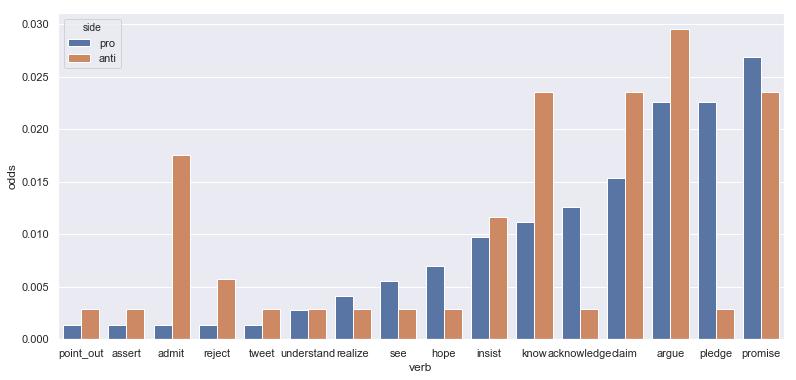

In [93]:
fig,ax = plt.subplots(figsize=(13,6))
sns.barplot(x="verb", y="odds", data=verb_odds_df.loc[verb_odds_df.subject=='obama'], hue='side',ax=ax)

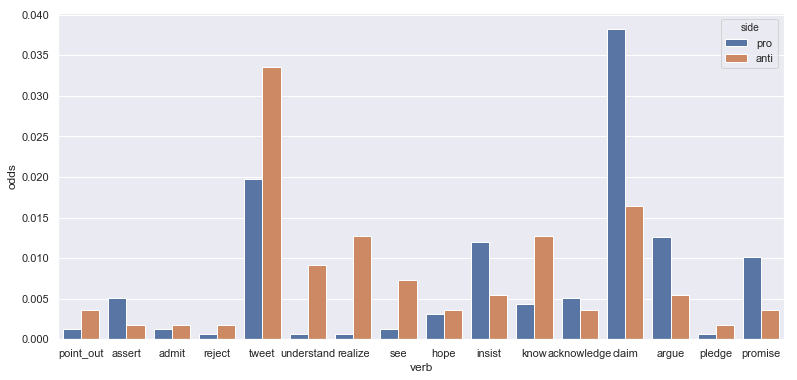

In [94]:
fig,ax = plt.subplots(figsize=(13,6))
sns.barplot(x="verb", y="odds", data=verb_odds_df.loc[verb_odds_df.subject=='trump'], hue='side',ax=ax)

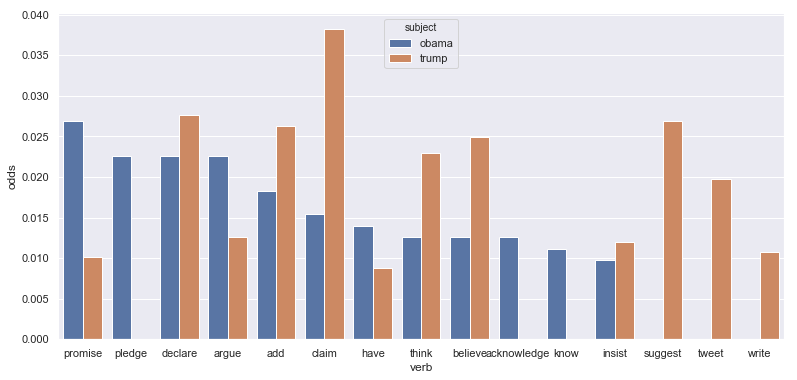

In [69]:
fig,ax = plt.subplots(figsize=(13,6))
sns.barplot(x="verb", y="odds", data=verb_odds_df.loc[verb_odds_df.side=='pro'], hue='subject',ax=ax)
#ax.set_xticklabels(labels=verb_odds_df.verb.values,rotation=70,fontsize=20)

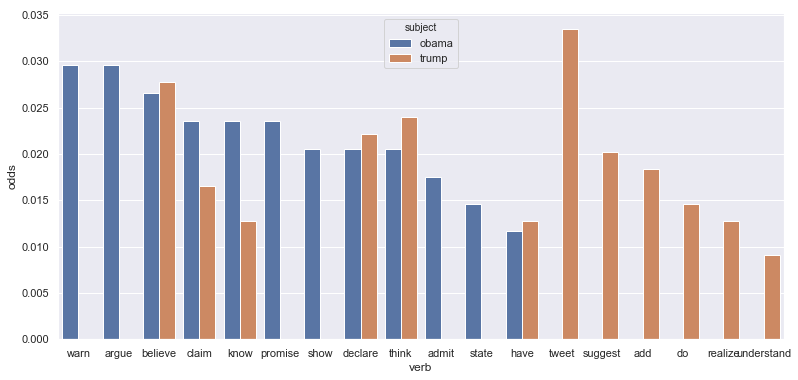

In [70]:
fig,ax = plt.subplots(figsize=(13,6))
sns.barplot(x="verb", y="odds", data=verb_odds_df.loc[verb_odds_df.side=='anti'], hue='subject',ax=ax)
#ax.set_xticklabels(labels=verb_odds_df.verb.values,rotation=70,fontsize=20)

In [13]:
pro_anti_obama_verb_log_odds_ratios = do_log_odds(main_verbs_by_ent['cc']['pro']['obama'],
                                                     main_verbs_by_ent['cc']['anti']['obama'],ratios=True)
pro_anti_trump_verb_log_odds_ratios = do_log_odds(main_verbs_by_ent['cc']['pro']['trump'],
                                                     main_verbs_by_ent['cc']['anti']['trump'],ratios=True)

In [14]:
sorted_pro_anti_obama_verb_log_odds_ratios = sorted(pro_anti_obama_verb_log_odds_ratios.items(),
                                                    key=lambda x:x[1],reverse=True)
sorted_pro_anti_trump_verb_log_odds_ratios = sorted(pro_anti_trump_verb_log_odds_ratios.items(),
       key=lambda x:x[1],reverse=True)

In [15]:
verb_df,odds_ratios_df,subject_df,pref_df = [],[],[],[]
for v,o in sorted_pro_anti_obama_verb_log_odds_ratios[:10]+\
sorted_pro_anti_obama_verb_log_odds_ratios[-10:]:
    verb_df.append(v)
    odds_ratios_df.append(o)
    subject_df.append('obama')
    pref_df.append(o > 0)
verb_odds_df = pd.DataFrame({"verb":verb_df,
                            "log odds ratios":odds_ratios_df,
                            "subject":subject_df,
                            "pref":pref_df})

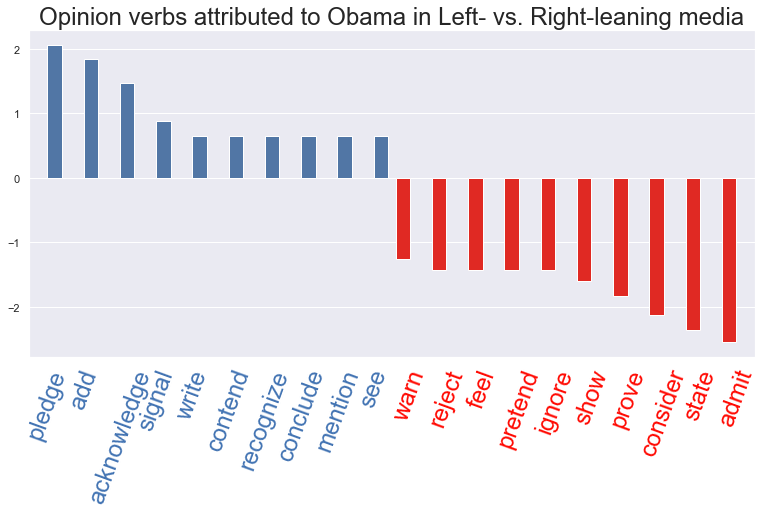

In [67]:
colors = ["#FF0B04","#4374B3"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

fig,ax = plt.subplots(figsize=(13,6))
sns.barplot(x="verb", y="log odds ratios", data=verb_odds_df, ax=ax, hue='pref')

ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=24,rotation=70)
ax.set_xlabel('')
ax.set_title('Opinion verbs attributed to Obama in Left- vs. Right-leaning media',fontsize=24)
ax.set_ylabel('')
ax.legend_.remove()


for tick in ax.get_xticklabels()[:10]: tick.set_color(colors[1])
for tick in ax.get_xticklabels()[10:]: tick.set_color(colors[0])

In [71]:
verb_df,odds_ratios_df,subject_df,pref_df = [],[],[],[]
for v,o in sorted_pro_anti_trump_verb_log_odds_ratios[:10]+\
sorted_pro_anti_trump_verb_log_odds_ratios[-10:]:
    verb_df.append(v)
    odds_ratios_df.append(o)
    subject_df.append('trump')
    pref_df.append(o > 0)
verb_odds_df = pd.DataFrame({"verb":verb_df,
                            "log odds ratios":odds_ratios_df,
                            "subject":subject_df,
                            "pref":pref_df})

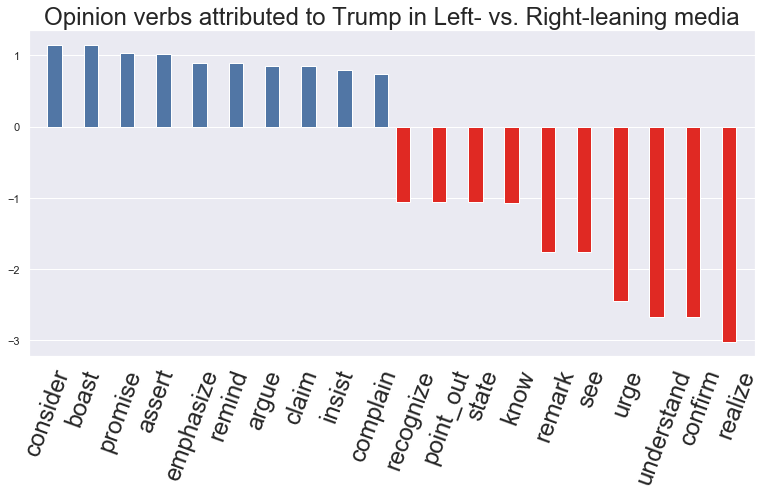

In [73]:
colors = ["#FF0B04","#4374B3"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

fig,ax = plt.subplots(figsize=(13,6))
sns.barplot(x="verb", y="log odds ratios", data=verb_odds_df, ax=ax, hue='pref')

ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=24,rotation=70)
ax.set_xlabel('')
ax.set_title('Opinion verbs attributed to Trump in Left- vs. Right-leaning media',fontsize=24)
ax.set_ylabel('')
ax.legend_.remove()

# Case study: Log odds of words in quotes from scientists in L vs. R-wing media

In [60]:
SCIENTIST_SOURCES = set(['scientist','researcher'])

In [7]:
scientist_quotes = [q for q in good_quotes if q['main subject lemma coref'] in SCIENTIST_SOURCES]
len(scientist_quotes)

9855

In [8]:
scientist_quotes[0]

{'quote lemmas': ['that',
  'human',
  'be',
  'the',
  'dominant',
  'cause',
  'of',
  '"',
  'unprecedented',
  '"',
  'warming',
  'of',
  'the',
  'planet',
  'since',
  'the',
  '1950'],
 'quote lemmas coref': ['that',
  'human',
  'be',
  'the',
  'dominant',
  'cause',
  'of',
  '"',
  'unprecedented',
  '"',
  'warming',
  'of',
  'the',
  'planet',
  'since',
  'the',
  '1950'],
 'verb lemmas': ['be', 'now', '95', '%', 'certain'],
 'verb lemmas coref': ['be', 'now', '95', '%', 'certain'],
 'main verb lemma': 'certain',
 'main verb lemma coref': 'certain',
 'subject lemmas': ['scientist'],
 'subject lemmas coref': ['scientist'],
 'main subject lemma': 'scientist',
 'main subject lemma coref': 'scientist',
 'neg lemmas': None,
 'main neg lemma': None,
 'quote text': ['that',
  'humans',
  'are',
  'the',
  'dominant',
  'cause',
  'of',
  '"',
  'unprecedented',
  '"',
  'warming',
  'of',
  'the',
  'planet',
  'since',
  'the',
  '1950s'],
 'verb text': ['are', 'now', '95', '

In [22]:
anti_scientist_quotes = [q for q in scientist_quotes if q['source'] in ANTI_CC_URLS]
pro_scientist_quotes = [q for q in scientist_quotes if q['source'] in PRO_CC_URLS]

In [23]:
len(anti_scientist_quotes),len(pro_scientist_quotes)

(2996, 5917)

In [29]:
anti_sci_quote_toks = [q['quote lemmas'] for q in anti_scientist_quotes]
pro_sci_quote_toks = [q['quote lemmas'] for q in pro_scientist_quotes]
anti_sci_quote_toks = [item.lower() for sublist in anti_sci_quote_toks for item in sublist]
pro_sci_quote_toks = [item.lower() for sublist in pro_sci_quote_toks for item in sublist]
len(pro_sci_quote_toks),len(anti_sci_quote_toks)

(104863, 54308)

In [30]:
log_odds_ratios_pro_anti_sci_quotes = do_log_odds(pro_sci_quote_toks,anti_sci_quote_toks)

In [31]:
sorted(log_odds_ratios_pro_anti_sci_quotes.items(),key=lambda x:x[1],reverse=True)[-100:]

[('450', -1.7566411849483894),
 ('swamp', -1.7566411849483894),
 ('error', -1.7566411849483894),
 ('plain', -1.7566411849483894),
 ('telescope', -1.7566411849483894),
 ('forecasting', -1.7566411849483894),
 ('exciting', -1.7566411849483894),
 ('door', -1.7566411849483894),
 ('quieter', -1.7566411849483894),
 ('#', -1.7566411849483894),
 ('caribbean', -1.7566411849483894),
 ('outer', -1.7566411849483894),
 ('crowd', -1.7566411849483894),
 ('cod', -1.7566411849483894),
 ('origin', -1.7566411849483894),
 ('compile', -1.7566411849483894),
 ('58', -1.7566411849483894),
 ('tectonic', -1.7566411849483894),
 ('mobile', -1.7566411849483894),
 ('sahara', -1.7566411849483894),
 ('installation', -1.7566411849483894),
 ('fukushima', -1.7566411849483894),
 ('productive', -1.7566411849483894),
 ('mitigation', -1.7566411849483894),
 ('book', -1.7566868936177982),
 ('thick', -1.7566868936177982),
 ('1998', -1.7566868936177982),
 ('operate', -1.7566868936177982),
 ('limited', -1.7566868936177982),
 ('th

# Case study: Log odds of op. attr. verbs for scientists in L vs. R-wing media

In [35]:
anti_sci_verb_toks = [q['main verb lemma'].lower() for q in anti_scientist_quotes]
pro_sci_verb_toks = [q['main verb lemma'].lower() for q in pro_scientist_quotes]
#anti_sci_verb_toks = [item.lower() for sublist in anti_sci_verb_toks for item in sublist]
#pro_sci_verb_toks = [item.lower() for sublist in pro_sci_verb_toks for item in sublist]
len(pro_sci_verb_toks),len(anti_sci_verb_toks)

(5917, 2996)

In [36]:
log_odds_ratios_pro_anti_sci_verbs = do_log_odds(pro_sci_verb_toks,anti_sci_verb_toks)

In [37]:
sorted(log_odds_ratios_pro_anti_sci_verbs.items(),key=lambda x:x[1],reverse=True)

[('forecast', 1.7188707210440524),
 ('testify', 1.5178614442344986),
 ('reveal', 1.2670597387941978),
 ('confirm', 1.2104406259409997),
 ('establish', 1.112570305576166),
 ('indicate', 1.1118886789532354),
 ('assume', 1.0805493157736095),
 ('expect', 1.0668008777029443),
 ('hypothesize', 0.9304228647839144),
 ('ensure', 0.9293979603556124),
 ('model', 0.9293979603556124),
 ('cause', 0.9293979603556124),
 ('identify', 0.9293979603556124),
 ('contend', 0.8612605735591584),
 ('recognize', 0.8243803181045773),
 ('fear', 0.8098179815212853),
 ('stress', 0.7869832103658173),
 ('debate', 0.7067711403411268),
 ('infer', 0.7060852758486105),
 ('realize', 0.6436135772067659),
 ('certain', 0.6424066235738026),
 ('feel', 0.6195904296790916),
 ('decide', 0.5241109448713995),
 ('learn', 0.5105880658601343),
 ('agree', 0.4991967076994326),
 ('sure', 0.4914244104576523),
 ('tell', 0.46907903438180854),
 ('study', 0.4194513500829044),
 ('project', 0.4191028310497665),
 ('emphasize', 0.41858115286953806

# Scientist quotes themselves

In [42]:
pd.set_option('max_colwidth', 400)

In [38]:
anti_sci_quotes = [q['quote text'] for q in anti_scientist_quotes]
pro_sci_quotes = [q['quote text'] for q in pro_scientist_quotes]

In [40]:
anti_sci_quote_strs = [' '.join(x) for x in anti_sci_quotes]
pro_sci_quote_strs = [' '.join(x) for x in anti_sci_quotes]

In [43]:
pd.DataFrame(anti_sci_quote_strs[:100])

,0
0,"the system is an indispensable tool for measuring local temperatures , and that its readings are buttressed by the consensus drawn from the 8,000 surface stations that make up the Cooperative Observer Program , the overall national system of which the 1,218 stations in the Historical Climatology Network are just a part"
1,whether the adjustments were appropriate
2,"Bremer Canyon , for example , is home to the Southern Hemisphere 's largest seasonal gathering of killer whales and often hosts traveling sharks , dolphins , squids and birds"
3,which did its best to deny that the Pause was a thing
4,it was wrong than actually looking at the data
...,...
95,"it is currently warming , albeit very slowly , but that the warming is n’t being caused by humans"
96,They found that the age of the trash introduced an intriguing new timeline for the Byzantine decline
97,"that trash disposal — once a well - organized and reliable service in outpost cities like Elusa — ceased around the middle of the sixth century , about 100 years prior to the empire 's collapse"
98,"This suggested there was a failure of infrastructure , which happens when a city is about to collapse"


# How each side describes different source entities

In [110]:
POS_ADJS = set(['novel','new'])
NEG_ADJS = set(['debunked'])

GENERIC_ADJS = set(['many','numerous','multiple'])

## Scientists as sources

For this, we look at the broader lemmas that are part of the subtree of instances of "scientist", "researcher", etc.

In [61]:
quotes_from_scientists_dict = defaultdict(dict)

In [66]:
good_quotes[0].keys()

dict_keys(['quote lemmas', 'quote lemmas coref', 'verb lemmas', 'verb lemmas coref', 'main verb lemma', 'main verb lemma coref', 'subject lemmas', 'subject lemmas coref', 'main subject lemma', 'main subject lemma coref', 'neg lemmas', 'main neg lemma', 'quote text', 'verb text', 'main verb text', 'subject text', 'main subject text', 'is neg', 'source', 'stance', 'topic'])

In [67]:
contains_el(good_quotes[0]['subject lemmas'],SCIENTIST_SOURCES)

False

In [68]:
good_quotes[0]['subject lemmas']

['the', 'pro', '-', 'Trump', 'LaRouche', 'PAC', ',', 'which', 'believe', ',']

In [72]:
for topic in ['cc','vax']:
    for side in ['anti','pro']:
        qs_from_scientists = [q for q in good_quotes if q['topic'] == topic and q['stance'] == side and 
                             contains_el(q['subject lemmas'],SCIENTIST_SOURCES)]
        quotes_from_scientists_dict[topic][side] = qs_from_scientists

In [73]:
print(len(quotes_from_scientists_dict['cc']['pro']))
print(len(quotes_from_scientists_dict['cc']['anti']))

print(len(quotes_from_scientists_dict['vax']['pro']))
print(len(quotes_from_scientists_dict['vax']['anti']))

8447
4027
373
387


In [80]:
scientist_subject_lemmas_dict = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        subj_lemmas_scientists = [q['subject lemmas'] for q in quotes_from_scientists_dict[topic][side]]
        subj_lemmas_scientists = [item.lower() for sublist in subj_lemmas_scientists for item in sublist]
        scientist_subject_lemmas_dict[topic][side] = subj_lemmas_scientists

In [111]:
sorted(Counter(scientist_subject_lemmas_dict['cc']['pro']).items(),key=lambda x:x[1],reverse=True)

[('scientist', 5909),
 ('the', 3938),
 (',', 3459),
 ('researcher', 2576),
 ('a', 1957),
 ('of', 1808),
 ('at', 1467),
 ('and', 1282),
 ('climate', 1164),
 ('university', 901),
 ('who', 764),
 ('in', 717),
 ('study', 426),
 ('research', 390),
 ('-', 363),
 ('for', 357),
 ('’s', 352),
 ('some', 320),
 ('an', 301),
 ('lead', 281),
 ('with', 271),
 ('by', 260),
 ('be', 251),
 ('on', 242),
 ('author', 238),
 ('institute', 230),
 ('many', 227),
 ('senior', 224),
 ('national', 223),
 ('from', 222),
 ('atmospheric', 208),
 ('center', 197),
 ('nasa', 194),
 ('-pron-', 178),
 ('one', 170),
 ('environmental', 168),
 ('other', 159),
 ('to', 142),
 ('state', 141),
 ('change', 139),
 ('group', 136),
 ('report', 136),
 ('political', 133),
 ('california', 132),
 ('most', 130),
 ('new', 128),
 ('have', 121),
 ('work', 119),
 ('team', 110),
 ('"', 110),
 ('that', 108),
 ('science', 104),
 ('james', 101),
 ('michael', 99),
 ('dr.', 99),
 ('chief', 98),
 ('not', 97),
 ('international', 90),
 ('hansen', 8

In [112]:
sorted(Counter(scientist_subject_lemmas_dict['cc']['anti']).items(),key=lambda x:x[1],reverse=True)

[('scientist', 2574),
 ('the', 1835),
 ('researcher', 1478),
 (',', 1314),
 ('of', 767),
 ('a', 703),
 ('at', 546),
 ('and', 511),
 ('climate', 491),
 ('university', 395),
 ('in', 366),
 ('who', 285),
 ('-', 191),
 ('study', 190),
 ('research', 177),
 ('for', 147),
 ('with', 141),
 ("'s", 128),
 ('some', 127),
 ('lead', 118),
 ('nasa', 118),
 ('institute', 116),
 ('an', 110),
 ('national', 108),
 ('"', 106),
 ('on', 106),
 ('atmospheric', 105),
 ('author', 100),
 ('from', 98),
 ('be', 98),
 ('center', 96),
 ('many', 89),
 ('’s', 89),
 ('by', 85),
 ('-pron-', 79),
 ('senior', 75),
 ('one', 71),
 ('new', 69),
 ('earth', 63),
 ('group', 62),
 ('state', 61),
 ('to', 61),
 ('laboratory', 60),
 ('other', 59),
 ('most', 59),
 ('change', 58),
 ('team', 56),
 ('that', 56),
 ('environmental', 54),
 ('michael', 54),
 ('chief', 54),
 ('report', 54),
 ('science', 51),
 ('co', 50),
 ('dr.', 49),
 ('(', 49),
 (')', 48),
 ('global', 46),
 ('california', 45),
 ('have', 43),
 ('space', 43),
 ('percent',

In [83]:
log_odds_ratios_pro_anti_cc_sci_subj_lemmas = do_log_odds(scientist_subject_lemmas_dict['cc']['pro'],
                                                         scientist_subject_lemmas_dict['cc']['anti'])

In [84]:
sorted(log_odds_ratios_pro_anti_cc_sci_subj_lemmas.items(),key=lambda x:x[1],reverse=True)

[('both', 2.256274006239917),
 ('e.', 2.161257205207995),
 ('netherlands', 2.1096144693325356),
 ('advocate', 2.1096144693325356),
 ('a.', 1.9379641100023743),
 ('carolina', 1.9377081528332225),
 ('chairman', 1.8731509458697841),
 ('b.', 1.8731509458697841),
 ('pieter', 1.8731509458697841),
 ('health', 1.8045765853418452),
 ('social', 1.804357953817576),
 ('china', 1.804139388906119),
 ('d.', 1.804139388906119),
 ('j.', 1.7679716196299735),
 ('britain', 1.7302126019797082),
 ('economic', 1.7300127316248237),
 ('george', 1.6909731995083064),
 ('h.', 1.6499513391728415),
 ('methane', 1.6499513391728415),
 ('rob', 1.5629212777538803),
 ('post', 1.5629212777538803),
 ('williams', 1.5629212777538803),
 ('mr.', 1.5629212777538803),
 ('alan', 1.5629212777538803),
 ('working', 1.5629212777538803),
 ('lee', 1.5629212777538803),
 ('peters', 1.5165450585837559),
 ('glen', 1.4677362068424928),
 ('r.', 1.4677362068424928),
 ('north', 1.4677362068424928),
 ('overwhelming', 1.4677362068424928),
 ('pr

In [85]:
sorted(log_odds_ratios_pro_anti_cc_sci_subj_lemmas.items(),key=lambda x:x[1],reverse=False)

[('cato', -3.4011686419006932),
 ('knappenberger', -3.3205412708967676),
 ('chip', -3.3205412708967676),
 ('man', -2.9149038455521454),
 ('pat', -2.9149038455521454),
 ('may', -2.781329378257676),
 ('very', -2.627135625615818),
 ('cold', -2.627135625615818),
 ('army', -2.444770997862451),
 ('visit', -2.444770997862451),
 ('insist', -2.444770997862451),
 ('engineers', -2.444770997862451),
 ('michaels', -2.2827129984914873),
 ('greenbelt', -2.2217379840532954),
 ('libertarian', -2.2217379840532954),
 ('climatologist', -2.2215843774438566),
 ('marshall', -2.2215843774438566),
 ('famous', -2.2215843774438566),
 ('turner', -2.2215843774438566),
 ('adams', -2.2215843774438566),
 ('gaia', -2.2215843774438566),
 ('geophysics', -2.2215843774438566),
 ('nongovernmental', -2.2215843774438566),
 ('perovich', -2.2215843774438566),
 ('nancy', -2.2215843774438566),
 ('16', -2.2215843774438566),
 ('ohio', -2.1348371609193),
 ('palisades', -2.0881635167588257),
 ('csiro', -1.9339697641169677),
 ('danis

In [ ]:
# famous, skeptical, outspoken, distinguished

# How each side describes scientists (in quotes)

# When a scientist is described as an "expert", or the source entity is simply "expert", is the quote stance different?

# Does each side simplify/essentialize the other side's arguments?

For example, does pro-cc news embed something along the lines of "climate change is a hoax" more than anti-cc news?

And does anti-cc news embed something along the lines of "the world is ending" more than pro-cc news?